In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import math
from scipy.stats.mstats import gmean
from scipy.stats import gamma,poisson,linregress,beta,norm,lognorm
from scipy import optimize
import time
import random
import pickle as pkl
from cratrcountr import *
%matplotlib inline

For our example data, we will use the counts of the Apollo 15 landing site from Robbins et al. (2014) provided by Stuart Robbins.  They come from LROC NAC image M146959973L.  The diameters are in units of pixels, and an adjustment is made for pixel size.  The area is an estimated area of the image.  It is not properly buffered, and it does not represent a clearly identified geologic unit per se.  These values are uncertain and could be wrong.  These data are for example purposes only.

In [6]:
cfactor=np.cos(math.pi*(26 + 11/60)/180)*0.626608880720610
rawd = pd.read_csv('M146959973L.txt',delimiter='\t')*cfactor
ds = np.array(sorted(rawd['D_wm'].tolist()))/1000
area = 4000*2215*cfactor**2/1000000

For our first example, we will plot a cumulative unbinned plot.  This presentation of the cumulative plot shows the cumulative number of craters as a function.  Without factoring in observational error, the cumulative plot is, of course, a step function.  Its maximum likelihood value begins on the right at 1/area for all diameters less than or equal to the diameter of the largest crater.  Once it reaches the second largest crater, the value jumps to 2/area, and it continues to climb with each crater.  The solid line shows the maximum likelihood value, the dashed line shows the medium (50th percentile) value, and the dotted lines show 1σ error bars.  In the recommended default form, this plot does not show the positions of the individual craters.  That is because the craters themselves are plotted only at the right-most part of each step in the step function, and visualizing the step function at only the craters produces a skewed view of the plot for low N.

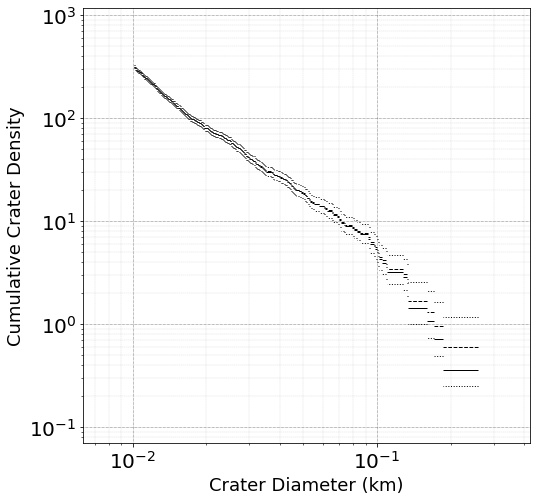

In [97]:
ax=plot_cumulative_unbinned(ds,area,color='black')

If we want to plot the maximum likelihood value for each crater at each crater's diameter, we can do that.  The maximum likelihood value of the crater density is equal to (cumulative count)/(area).

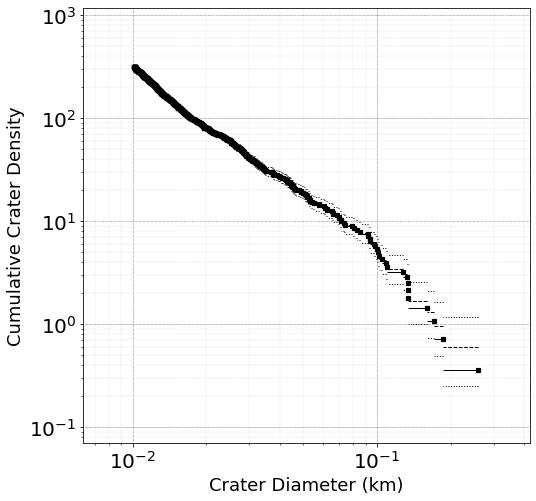

In [106]:
ax=plot_cumulative_unbinned(ds,area,color='black',max_point=True)

We can also change the color of the plot and the overplotted craters.

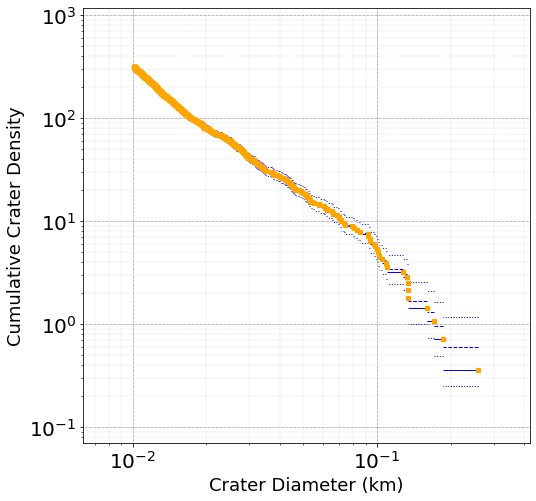

In [107]:
ax=plot_cumulative_unbinned(ds,area,color='blue',max_point=True,crater_color='orange')

We can also plot the median values of expected density for each crater according to Poisson statistics.  This median value will always exceed the maximum likelihood value, but the difference will be come increasingly negligible with increasing N.

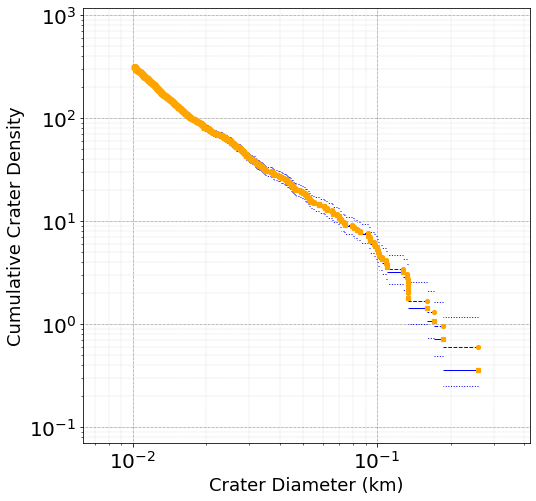

In [128]:
ax=plot_cumulative_unbinned(ds,area,color='blue',max_point=True,med_point=True,crater_color='orange')

We can plot the craters with vertical lines indicating the error bars, too.

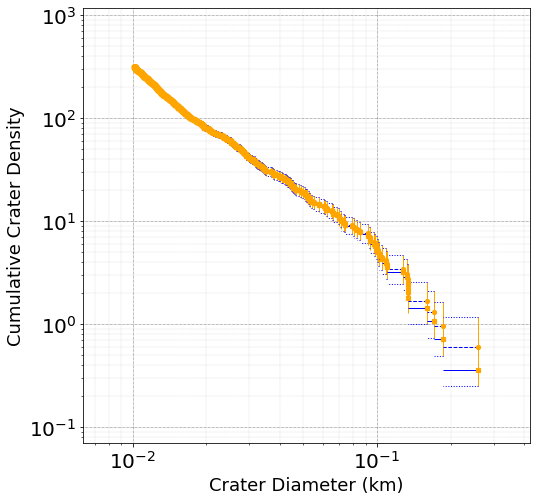

In [129]:
ax=plot_cumulative_unbinned(ds,area,color='blue',max_point=True,med_point=True,crater_lines=True,\
                            crater_color='orange')

We can also remove the lines showing the step function.

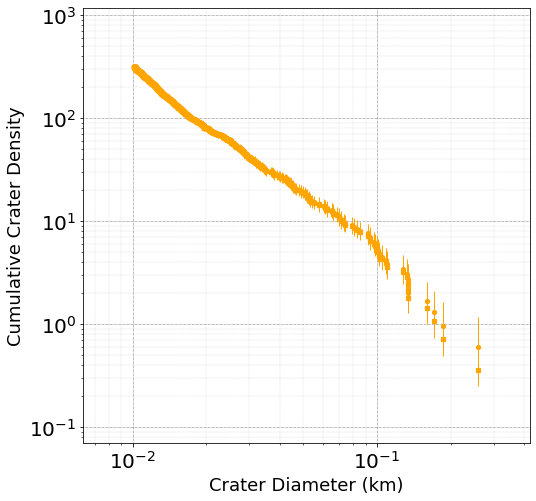

In [130]:
ax=plot_cumulative_unbinned(ds,area,max_point=True,med_point=True,crater_lines=True,\
                            crater_color='orange',plot_lines=False)

And we can reproduce the legacy version of the plot with sqrt(N) error bars and no lines showing the actual cumulative step function.  This version shows the median value equal to the maximum likelihood value, with both equal to (cumulative count)/(area).  This version is highly misleading and should not be used.

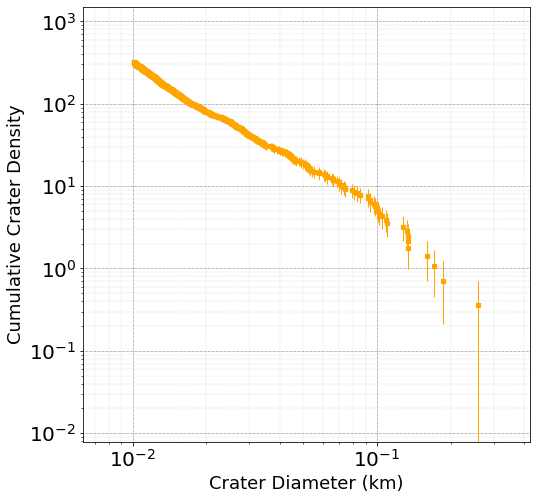

In [131]:
ax=plot_cumulative_unbinned(ds,area,max_point=True,crater_lines=True,sqrtN=True,\
                            crater_color='orange',plot_lines=False)

We can plot both the legacy version and the recommended plot together to show the differences.  Note how the differences are largest at low N, with the two plots converging at higher N.  To plot two plots together, pass the ax variable from the first plot to the second plot.

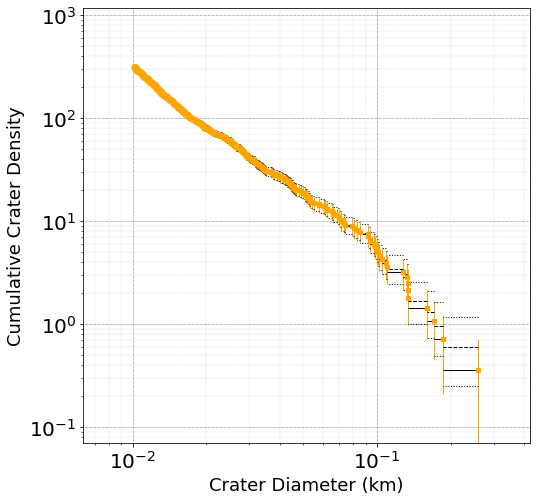

In [132]:
ax=plot_cumulative_unbinned(ds,area,max_point=True,crater_lines=True,sqrtN=True,\
                            crater_color='orange',plot_lines=False)
plot_cumulative_unbinned(ds,area,color='black',ax=ax)

Now, in real life, there is considerable error in human measurements of crater diameters.  To adjust for this, we can incorporate error modeled as purely random error, where the error in measuring each diameter is uncorrelated from each other.  To do this, we use a kernel that assumes normally distributed error with the standard deviation equal to a certain fraction of the diameter, with that fraction set by the random_sigma variable.  This spreads out each crater's contribution to create a much smoother continuous function than the step function.

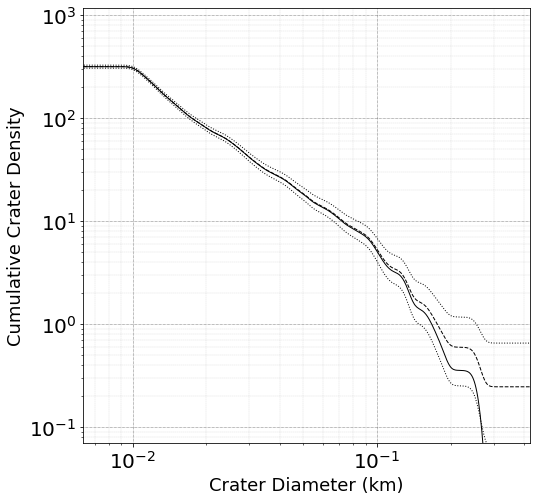

In [136]:
ax=plot_cumulative_unbinned(ds,area,color='black',random_sigma=0.05)

We can show this with the crater maximum values superimposed.  By showing both together, we can see how apparent structure in the data assuming no random diameter measurement error becomes muted for a diameter error of just 5%.

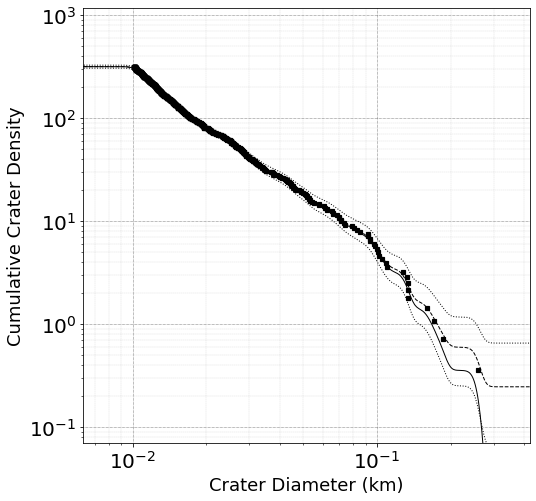

In [138]:
ax=plot_cumulative_unbinned(ds,area,color='black',random_sigma=0.05,max_point=True)

For a more realistic diameter error of 10%, we can see how the apparent structure in the data almost entirely disappears, and we can see how the largest crater point becomes an outlier.

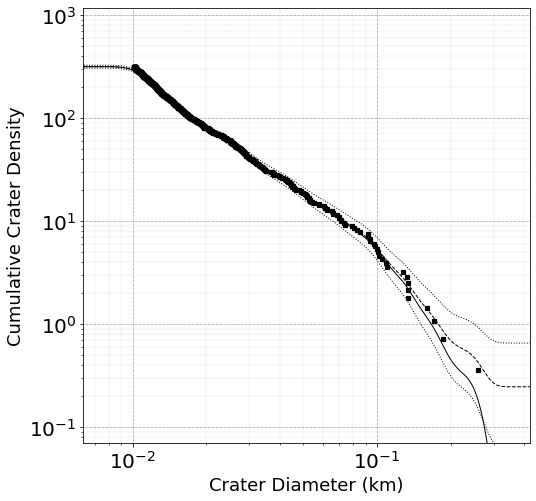

In [139]:
ax=plot_cumulative_unbinned(ds,area,color='black',random_sigma=0.10,max_point=True)

We can also plot the default version with no random diameter error along with the version with random diameter error.  Note how the version with random diameter error approaches a line connecting the midpoints of the version without diameter error.  There is also a slight edge case deviation for the lowest diameters, causing the version with diameter error to deviate slightly below the version without diameter error.  This is caused by craters below the diameter cutoff not generating a partial contribution to craters above the cutoff.

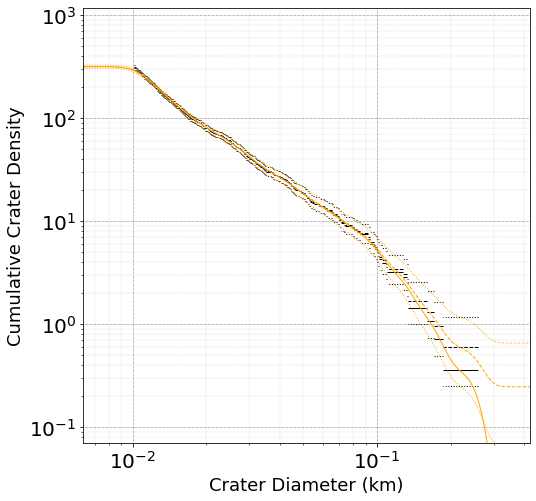

In [142]:
ax=plot_cumulative_unbinned(ds,area,color='orange',random_sigma=0.10)
plot_cumulative_unbinned(ds,area,color='black',ax=ax)

To make it easier to read, we can also produce a binned version of the cumulative plot.  In this binned version, the maximum likelihood value is shown as a filled circle, and the median value is shown as a crossbar.

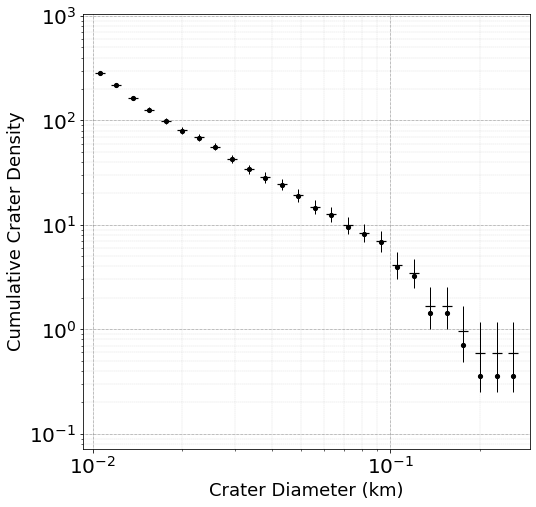

In [147]:
ax=plot_cumulative_binned(ds,area)

And we can show it plotted with the unbinned version.

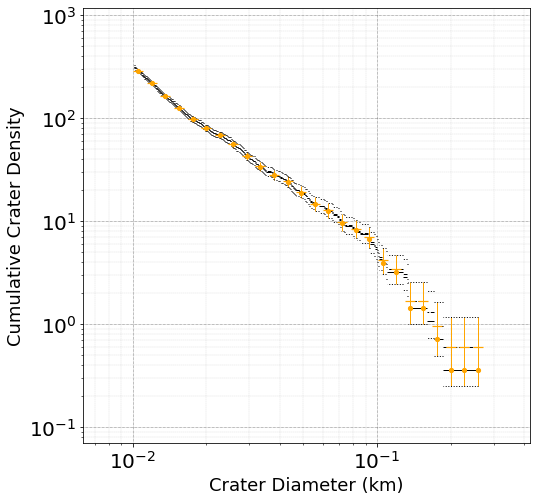

In [151]:
ax=plot_cumulative_binned(ds,area,color='orange')
plot_cumulative_unbinned(ds,area,color='black',ax=ax)

The bin width is set by the bin_width_exponent variable. The multiplicative factors that produce bin width in log space are set according to 2 to the power of the bin_width_exponent variable.  The default value is a parameter imported from cratrcountr, neukum_bwe, which gives the bin width estimate required to create Neukum's 18/decade bins. 

In [161]:
2**neukum_bwe,2**(neukum_bwe*18)

(1.1364636663857248, 10.000000000000002)

We can set a different bin_width_exponent.  Here is a cumulative plot with wider bins.

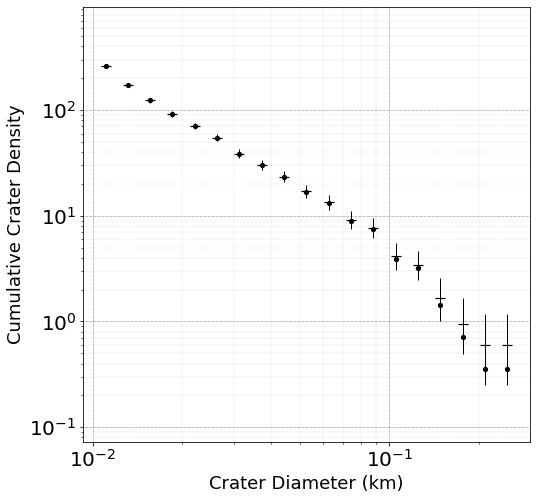

In [163]:
plot_cumulative_binned(ds,area,bin_width_exponent=0.25)

Or much wider bins.  When plotted this wide, key details of the cratering curve, such as the equilibrium saturation inflection point, can no longer be seen.

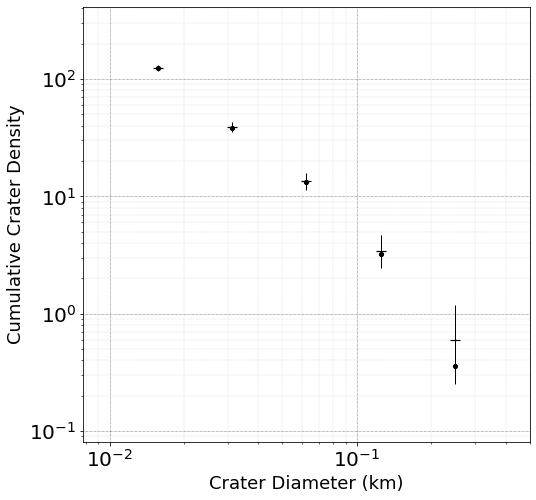

In [164]:
plot_cumulative_binned(ds,area,bin_width_exponent=1.0)

We can also define the diameter position of one of the bins as a reference point.  Here, we set one of the bins at a diameter of 0.1km, which is roughly the lowest diameter one can safely place a bin before the curve enters equilibrium saturation.

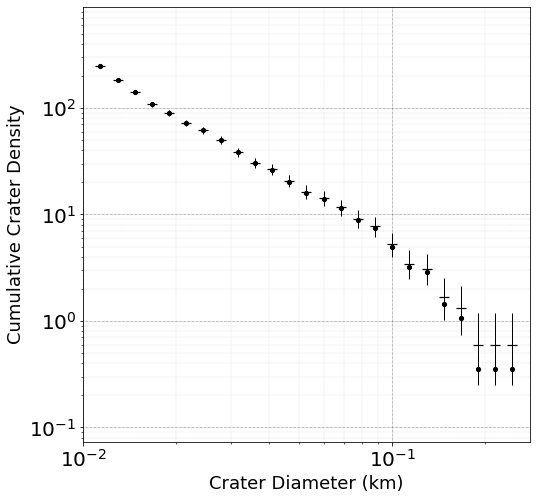

In [167]:
ax=plot_cumulative_binned(ds,area,reference_point=0.1)

We can also apply a small amount of random error.  This causes the curve to smooth out somewhat.  However, it also causes bins larger than the largest crater to appear.  Previously, these bins did exist, showing zero craters out to an infinitely large diameter, but for the sake of convenience the plot does not show them.  Now, the plot shows two additional bins showing fractional counts to account for the possibility that the single largest crater might actually fall in that bin.  When this happens, the maximum likelihood point actually falls below the 1σ lower bound.  For the largest diameter bin, the maximum likelihood point falls so far below the 1σ lower bound that it is off of the plot, approaching the form of a zero-crater bin.  For a zero-crater bin, the maximum likelihood is at 0, which falls at negative infinity on a log-log plot, and the median value is 0.693/area.

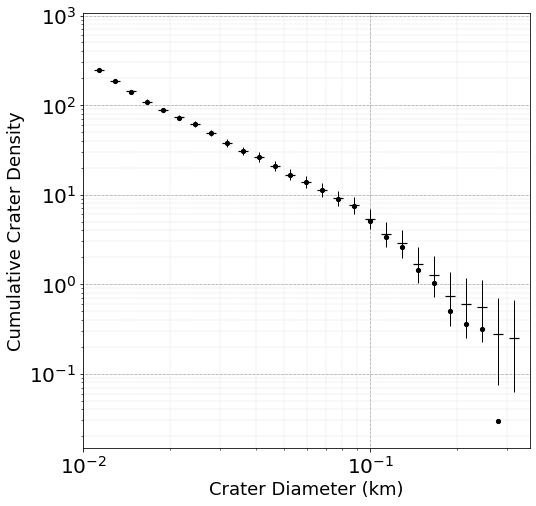

In [173]:
ax=plot_cumulative_binned(ds,area,reference_point=0.1,random_sigma=0.05)

In the default recommended version of this plot, the diameter axis (x-axis) position of the bin is plotted at the left edge of the bin.  This way, the bin shows the value of the cumulative function (which is a step function) at that bin.

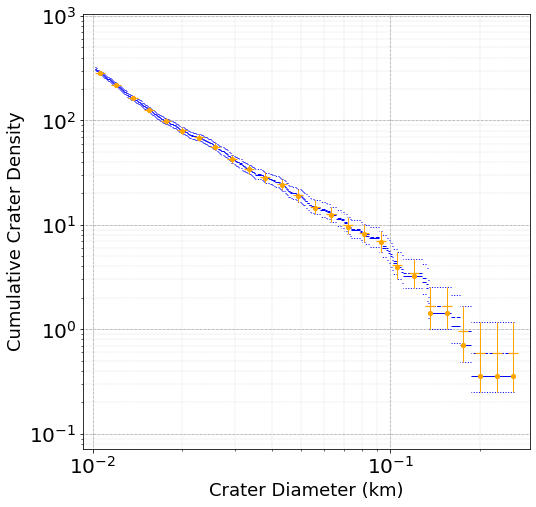

In [188]:
ax=plot_cumulative_unbinned(ds,area,color='blue')
plot_cumulative_binned(ds,area,x_axis_position='left',color='orange',ax=ax)

However, when the bin is plotted on the diameter axis at the center of the bin (in log space, not linear space), as has historically been very common, it does not necessarily plot on the cumulative function, instead tending to plot off to the right.  For this reason, this form of the plot is highly discouraged, but the code allows it in order to be able to reproduce legacy analyses using this incorrect plotting method.

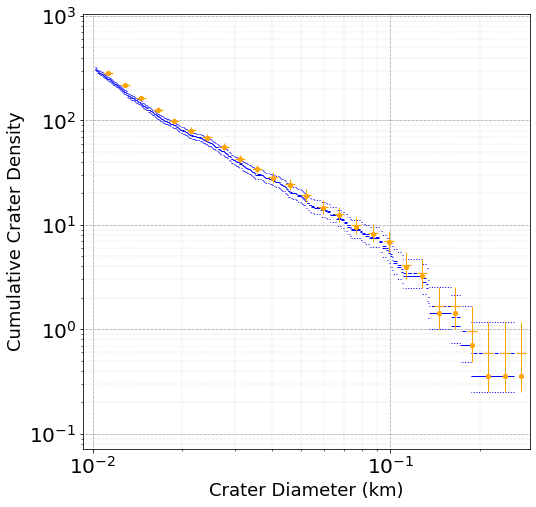

In [189]:
ax=plot_cumulative_unbinned(ds,area,color='blue')
plot_cumulative_binned(ds,area,x_axis_position='center',color='orange',ax=ax)

Here we can see the deviation between the correct version with the diameter axis position at the left-hand edge of the been in blue and the incorrect legacy version with the diameter axis position at the bin center in orange.

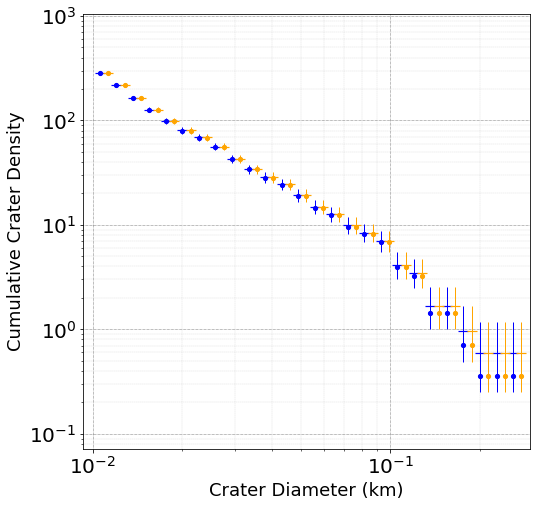

In [180]:
ax=plot_cumulative_binned(ds,area,x_axis_position='left',color='blue')
plot_cumulative_binned(ds,area,x_axis_position='center',color='orange',ax=ax)

This deviation becomes even bigger with wider bins.  This bias can be substantial, and it will lead to quite incorrect age results.

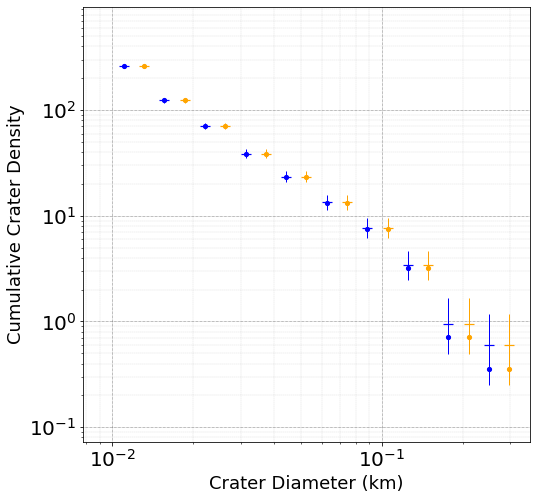

In [190]:
ax=plot_cumulative_binned(ds,area,x_axis_position='left',color='blue',bin_width_exponent=0.5)
plot_cumulative_binned(ds,area,x_axis_position='center',color='orange',ax=ax,bin_width_exponent=0.5)

Another common binning scheme that introduces a similar bias is to plot the bin on the diameter axis at the geometric mean of the diameters of the craters in the bin.  This scheme is highly discouraged, but we include it to allow the reproduction of legacy results.

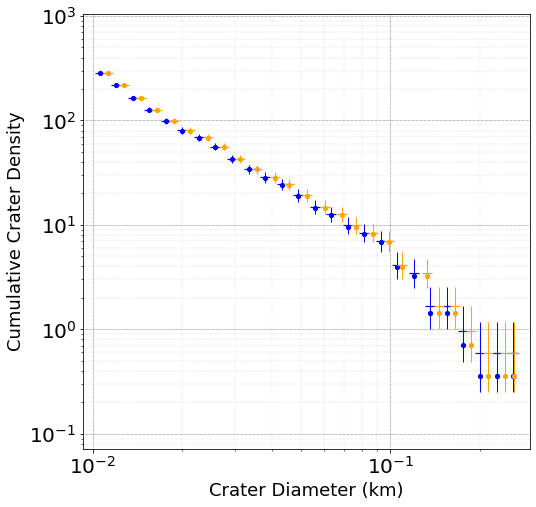

In [191]:
ax=plot_cumulative_binned(ds,area,x_axis_position='left',color='blue')
plot_cumulative_binned(ds,area,x_axis_position='gmean',color='orange',ax=ax)

Another very common practice that introduces substantial bias is to exclude zero-crater bins.  This biases the cratering curve to the right at higher diameters where you find zero-crater bins, leading to artificially older ages and shallower slopes.  Here we see geometric mean binning without zero-crater bins in orange and the recommended version in blue (left-hand bin edge bins with zero-crater bins included).

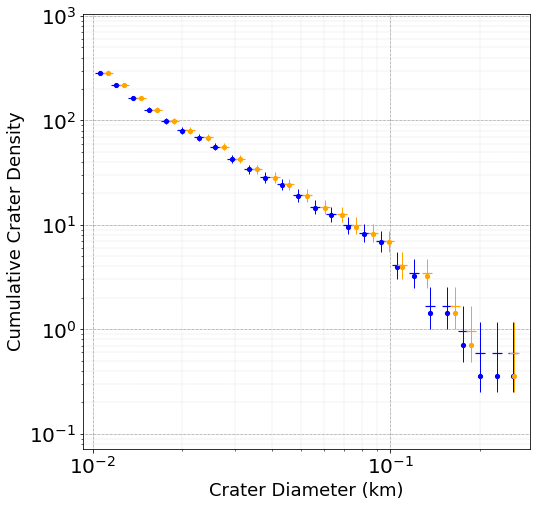

In [192]:
ax=plot_cumulative_binned(ds,area,x_axis_position='left',color='blue')
plot_cumulative_binned(ds,area,x_axis_position='gmean',color='orange',ax=ax,skip_zero_crater_bins=True)

The cratrcountr code allows the plotting of a fourth binning scheme for cumulative plots.  This is the binning scheme used by Michael and Neukum (2010).  In this binning scheme, the largest craters are not binned, while the rest of the craters are plotted on the diameter axis at the bin center.  This binning scheme also introduces substantial deviations, and we only include it for the reproduction of previous results.  This binning scheme requires skipping zero crater bins, and it will thrown an error if skip_zero_crater_bins is not set to True.

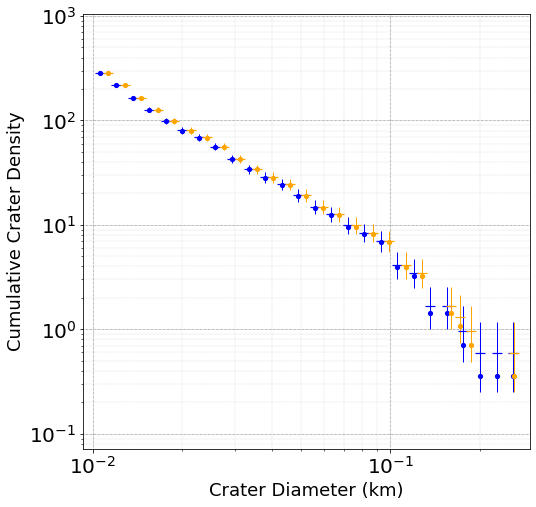

In [186]:
ax=plot_cumulative_binned(ds,area,x_axis_position='left',color='blue')
plot_cumulative_binned(ds,area,x_axis_position='Michael and Neukum (2010)',color='orange',ax=ax,\
                      skip_zero_crater_bins=True)

The cumulative plot has several issues that make it poorly suited for age calculations.  Most importantly, each bin depends on the bin next to it, leading to complex bin covariance issues.  The bins cannot be treated as independent from each other, which dramatically complicates the true error calculations.  For that reason, we strongly recommend using the incremental plot.  In the recommended version of the incremental plot, shown here, the diameter axis position is set by default to the left-hand bin edge.  Although we do not recommend it, this version can also be plotted at the bin center.

To convert a production function from cumulative space to incremental space, simply subtract a version of the production function for the right-hand edge of each bin:  incremental_pf(D)=cumulative_pf(D)-cumulative_pf(D*2^bin_width_exponent)

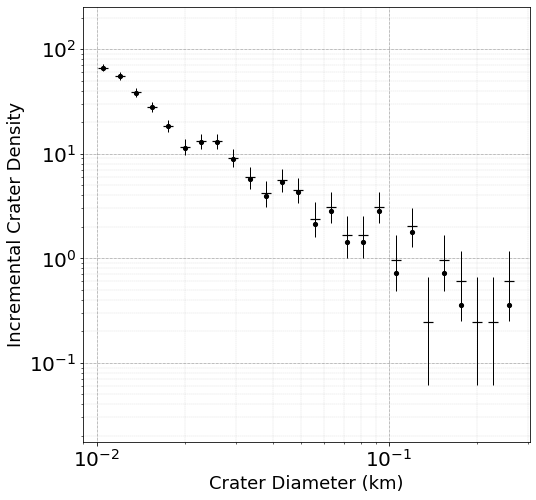

In [209]:
ax=plot_incremental(ds,area)

The incremental plot can also be adjusted for random diameter measurement error.

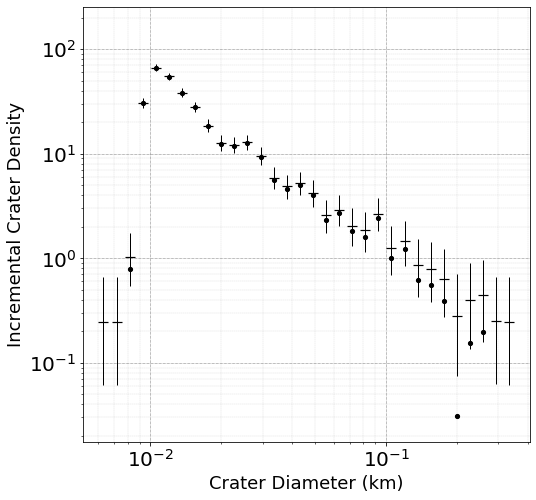

In [211]:
ax=plot_incremental(ds,area,random_sigma=0.05)

With the incremental plot with random error, we can also adjust how many bins will be added on each side, using adjustment factors that are multiplied by the diameters of the largest and smallest craters.

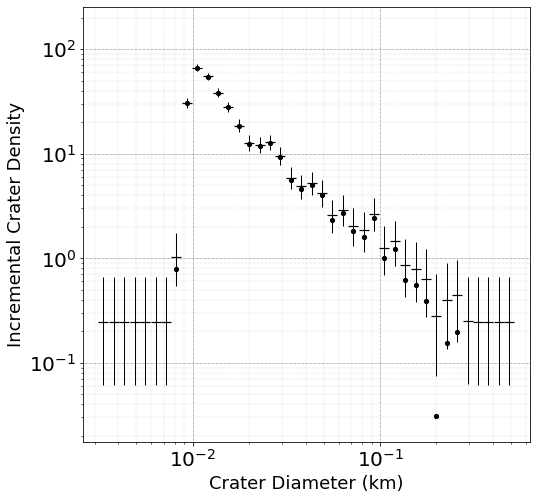

In [291]:
ax=plot_incremental(ds,area,random_sigma=0.05,lower_bin_adjustment=0.3,upper_bin_adjustment=2.0)

Another commonly used plotting technique is the differential plot.  It is equal to the incremental plot divided by the bin width, roughly approximating the derivative of a smoothed version of the cumulative plot.  In this version, the production function equals the derivative of the cumulativer version of the production function.  To be fully accurate, the differential plot requires an adjustment for the non-zero bin width, which requires knowing the value of the production function.  Because the production function is not always known, this creates an element of circular reasoning.  For this reason, the incremental plot is preferred.  In this example, the differential plot is shown with the "new" Neukum Production Function for the Moon.  For the standard version of this unrecommended plot type, the bins are plotted at their bin centers, but other options are available.  One of the options frequently (and incorrectly) used is to exclude zero-crater bins.  Because this biases the results and visually suggests a higher overall crater density, we do not recommend doing this except in order to reproduce previous results.

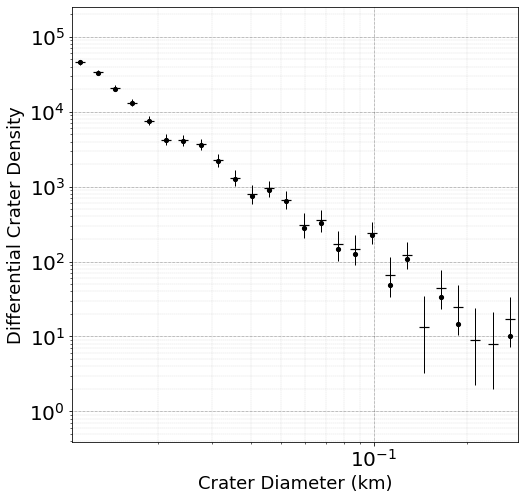

In [229]:
ax=plot_differential(ds,area,bin_width_exponent=neukum_bwe,do_correction=True,production_function=npf_new)

The value of the correction is not very large, even for fairly wide bins, but it can be seen.  Here, the uncorrected bins are shown in orange, with the corrected bins in black.

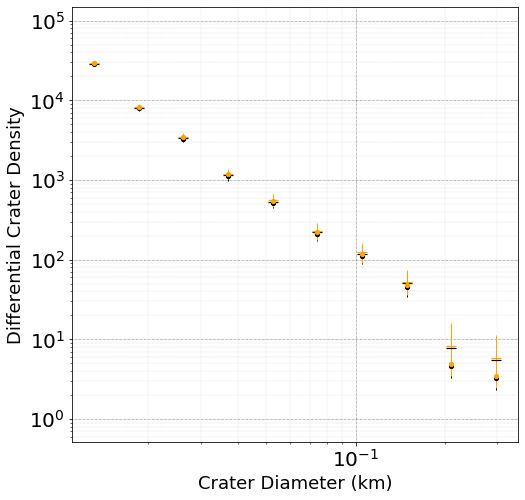

In [228]:
ax=plot_differential(ds,area,bin_width_exponent=0.5,do_correction=True,production_function=npf_new)
plot_differential(ds,area,bin_width_exponent=0.5,do_correction=False,color='orange',ax=ax)

A final plot is the R plot.  It is essentially a differential plot with a cumulative slope of -2 is removed from the data.  A line with a cumulative slope of -2 will plot as a flat line on an R plot.  Under the plotting recommendations of the Crater Analyses Techniques Working Group, the bins are plotted on the diameter axis at the geometric mean of the diameters of the craters in the bin, but here we plot them at the bin centers, which we believe better reflects the actual data.

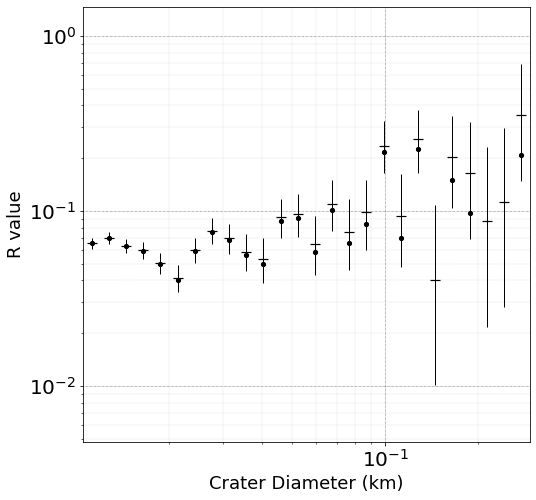

In [310]:
ax=plot_R(ds,area)

This example shows just how problematic it is to remove zero-crater bins, as is commonly (and incorrectly) done with R plots.  Without the zero-crater bins, the unsaturated portion of the curve appears to have a slope shallower than -2, similar to the slope to the saturated portion.  With the zero-crater bins included (see above), we can see that the unsaturated portion has a slope steeper than the saturated portion.  Here is a version without zero-crater bins.

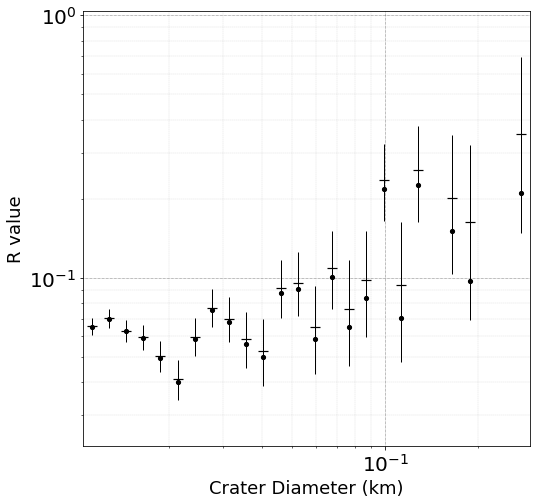

In [311]:
ax=plot_R(ds,area,skip_zero_crater_bins=True)

There is also a calculation function that produces the raw numbers for the plots.  When there is no random error, it outputs a pandas dataframe with the diameter of each crater and the value of the cumulative function for diameters smaller than or equal to that crater.  It shows the maximum likelihood, the median, and the upper and lower bound error bars.

In [247]:
unbinned_cumulative=calc_cumulative_unbinned(ds,area,n_points=2000)
unbinned_cumulative

,D,count,max,lower,median,upper,density_pdf,λ_pdf,P_pdf
0,0.260185,1,0.356955,0.346305,0.599095,0.578689,"[0.0, 0.001921137108881883, 0.0038422742177637...","[0.0, 0.005382009873530936, 0.0107640197470618...","[1.4756893413683766e-05, 2.883719465656689e-05..."
1,0.186915,2,0.713911,0.466457,0.954520,0.700990,"[0.0, 0.0022972275583687867, 0.004594455116737...","[0.0, 0.006435616356442121, 0.0128712327128842...","[1.8779479194597751e-06, 1.8779479194597751e-0..."
2,0.170814,3,1.070866,0.566274,1.310762,0.801767,"[0.0, 0.002641639507521637, 0.0052832790150432...","[0.0, 0.007400476439740133, 0.0148009528794802...","[6.803564798863631e-07, 6.803564798863631e-07,..."
3,0.160188,4,1.427821,0.653443,1.667306,0.889478,"[0.0, 0.002966124681868843, 0.0059322493637376...","[0.0, 0.008309512241545804, 0.0166190244830916...","[3.614711106171824e-07, 3.614711106171824e-07,..."
4,0.134509,5,1.784777,0.731792,2.023994,0.968175,"[0.0, 0.003276557232457614, 0.0065531144649152...","[0.0, 0.009179180025594048, 0.0183583600511880...","[2.3323027562585954e-07, 2.3323027562585954e-0..."
...,...,...,...,...,...,...,...,...,...
884,0.010177,885,315.905467,10.504076,316.143445,10.742037,"[0.0, 0.177375634487668, 0.354751268975336, 0....","[0.0, 0.49691269390556414, 0.9938253878111283,...","[8.047481686078572e-09, 8.047481686078572e-09,..."
885,0.010174,886,316.262422,10.510071,316.500400,10.748032,"[0.0, 0.1775646376148779, 0.3551292752297558, ...","[0.0, 0.4974421806829883, 0.9948843613659766, ...","[8.046296452104128e-09, 8.046296452104128e-09,..."
886,0.010170,887,316.619377,10.516064,316.857356,10.754024,"[0.0, 0.17775363486254422, 0.35550726972508845...","[0.0, 0.4979716509890418, 0.9959433019780836, ...","[8.045113402876332e-09, 8.045113402876332e-09,..."
887,0.010165,888,316.976333,10.522052,317.214311,10.760013,"[0.0, 0.17794262624059332, 0.35588525248118663...","[0.0, 0.4985011048515328, 0.9970022097030656, ...","[8.043932531809716e-09, 8.043932531809716e-09,..."


It also shows example PDFs for λ and crater density (λ/area), expressed as an array with values of λ or crater density and the corresponding array of probabilities.  Here are examples showing how to plot the PDFs for both λ and crater density for the largest bin (N=1).  Note how the maximum likelihood value of λ is at 1, and the median is at 1.68. 

([], <a list of 0 Text yticklabel objects>)

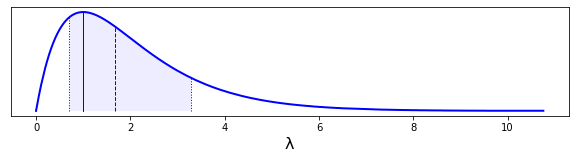

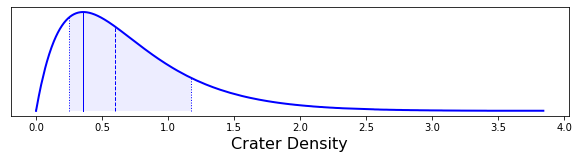

In [255]:
plot_pdf(unbinned_cumulative.iloc[0]['λ_pdf'],unbinned_cumulative.iloc[0]['P_pdf'])
plt.xlabel('λ',size=16)
plt.yticks([])
plot_pdf(unbinned_cumulative.iloc[0]['density_pdf'],unbinned_cumulative.iloc[0]['P_pdf'])
plt.xlabel('Crater Density',size=16)
plt.yticks([])

The calculation function produces a different format of output when random error is applied.  In this case, it outputs a tuple of numpy arrays representing the diameter values, the maximum value line, the lower bound, the median line, and the upper bound.  This example shows the output arrays and how to plot them.

In [237]:
X,max_line,lower_bound,med_line,upper_bound=calc_cumulative_unbinned(ds,area,n_points=2000,random_sigma=0.05)

Text(0, 0.5, 'Cumulative Crater Density')

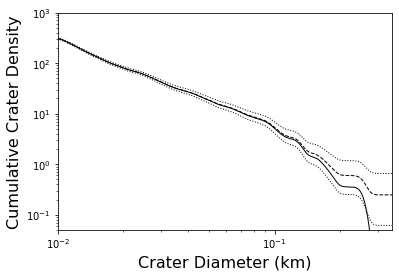

In [258]:
plt.loglog(X,max_line,'k')
plt.loglog(X,med_line,'k--')
plt.loglog(X,med_line-lower_bound,'k:')
plt.loglog(X,med_line+upper_bound,'k:')
plt.xlim(0.01,0.35)
plt.ylim(0.05,1000)
plt.xlabel('Crater Diameter (km)',size=16)
plt.ylabel('Cumulative Crater Density',size=16)

We also have a binned calculation function.  In this case, the version with random error is still binned.

In [276]:
binned_cumulative=calc_cumulative_binned(ds,area,n_points=2000,random_sigma=0.05)
binned_cumulative

,D,count,max,lower,median,upper,density_pdf,P_pdf,λ_pdf
0,0.010550,801.145013,285.972982,9.988678,286.210961,10.226637,"[0.0, 0.16150478483509983, 0.32300956967019967...","[8.155379810412658e-09, 8.155379810412658e-09,...","[0.0, 0.4524509690570132, 0.9049019381140264, ..."
1,0.011990,614.778066,219.448307,8.736436,219.686289,8.974392,"[0.0, 0.12604625895944674, 0.2520925179188935,...","[8.478552290555611e-09, 8.478552290555611e-09,...","[0.0, 0.3531149375570614, 0.7062298751141228, ..."
2,0.013626,461.454780,164.718743,7.554505,164.956729,7.792457,"[0.0, 0.09661088244479174, 0.19322176488958348...","[8.899072029255162e-09, 8.899072029255162e-09,...","[0.0, 0.2706525842452895, 0.541305168490579, 0..."
3,0.015485,354.953599,126.702579,6.612461,126.940569,6.850407,"[0.0, 0.07595413423433864, 0.15190826846867728...","[9.363483095362616e-09, 9.363483095362616e-09,...","[0.0, 0.21278330343773394, 0.4255666068754679,..."
4,0.017598,277.232424,98.959591,5.831592,99.197587,6.069531,"[0.0, 0.06071725831921579, 0.12143451663843158...","[9.888060242316171e-09, 9.888060242316171e-09,...","[0.0, 0.1700976376214693, 0.3401952752429386, ..."
5,0.020000,225.945145,80.652324,5.254515,80.890325,5.492446,"[0.0, 0.05055535279378532, 0.10111070558757064...","[1.0401212172555332e-08, 1.0401212172555332e-0...","[0.0, 0.1416293541143196, 0.2832587082286392, ..."
6,0.022729,191.023617,68.186898,4.823171,68.424905,5.061096,"[0.0, 0.04356946618058915, 0.0871389323611783,...","[1.0886973730208237e-08, 1.0886973730208237e-0...","[0.0, 0.12205859544552694, 0.24411719089105388..."
7,0.025831,157.632486,56.267756,4.372153,56.505771,4.610068,"[0.0, 0.036822844745234354, 0.0736456894904687...","[1.1528521359809193e-08, 1.1528521359809193e-0...","[0.0, 0.10315813123077451, 0.20631626246154902..."
8,0.029356,122.316245,43.661436,3.839608,43.899463,4.077507,"[0.0, 0.02959108150296951, 0.05918216300593902...","[1.2547923208312455e-08, 1.2547923208312455e-0...","[0.0, 0.08289855631914311, 0.16579711263828623..."
9,0.033362,96.068291,34.292089,3.391864,34.530132,3.629743,"[0.0, 0.02412638416513995, 0.0482527683302799,...","[1.3751433558449602e-08, 1.3751433558449602e-0...","[0.0, 0.06758936527177722, 0.13517873054355445..."


Here are plots of the PDFs of a bin with a fractional count of 0.56.

([], <a list of 0 Text yticklabel objects>)

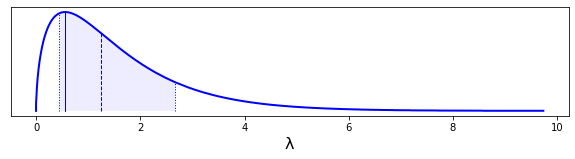

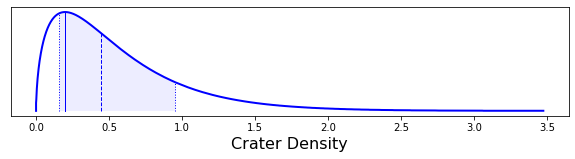

In [278]:
plot_pdf(binned_cumulative.iloc[-2]['λ_pdf'],binned_cumulative.iloc[-2]['P_pdf'])
plt.xlabel('λ',size=16)
plt.yticks([])
plot_pdf(binned_cumulative.iloc[-2]['density_pdf'],binned_cumulative.iloc[-2]['P_pdf'])
plt.xlabel('Crater Density',size=16)
plt.yticks([])

Here is the calculation function for the incremental plot.

In [292]:
binned_incremental=calc_incremental(ds,area,n_points=2000,random_sigma=0.05)
binned_incremental

,D,count,lower,max,median,upper,density_pdf,P_pdf,λ_pdf
0,0.006325,7.110338e-08,0.185757,2.538073e-08,0.247423,0.409740,"[0.0, 0.0014810431690717208, 0.002962086338143...","[0.004140502094270754, 0.004131914709624274, 0...","[0.0, 0.0041490994693807815, 0.008298198938761..."
1,0.007188,1.575015e-03,0.186066,5.622100e-04,0.247967,0.410080,"[0.0, 0.0014818307920236376, 0.002963661584047...","[0.004104327108906398, 0.004100280487817753, 0...","[0.0, 0.004151305972229661, 0.0083026119444593..."
2,0.008168,2.209448e+00,0.488698,7.886742e-01,1.029094,0.723488,"[0.0, 0.0023714524274017204, 0.004742904854803...","[1.4454412423379605e-06, 1.4454412423379605e-0...","[0.0, 0.006643555173588436, 0.0132871103471768..."
3,0.009283,8.562036e+01,3.196861,3.056265e+01,30.800697,3.434729,"[0.0, 0.021922185977716564, 0.0438443719554331...","[1.442497004115151e-08, 1.442497004115151e-08,...","[0.0, 0.061414367999023466, 0.1228287359980469..."
4,0.010550,1.864019e+02,4.763231,6.653716e+01,66.775172,5.001154,"[0.0, 0.042639969989830814, 0.0852799399796616...","[1.0963347802302171e-08, 1.0963347802302171e-0...","[0.0, 0.11945463883413117, 0.23890927766826234..."
5,0.011990,1.533463e+02,4.310935,5.473777e+01,54.975784,4.548848,"[0.0, 0.03595106189630979, 0.07190212379261958...","[1.1629090966390929e-08, 1.1629090966390929e-0...","[0.0, 0.10071585687211737, 0.20143171374423474..."
6,0.013626,1.064820e+02,3.576002,3.800932e+01,38.247359,3.813890,"[0.0, 0.02630570438655332, 0.05261140877310664...","[1.3206767828062321e-08, 1.3206767828062321e-0...","[0.0, 0.07369466764452605, 0.1473893352890521,..."
7,0.015485,7.770608e+01,3.041147,2.773760e+01,27.975661,3.279005,"[0.0, 0.020238705903542507, 0.0404774118070850...","[1.5051819746880016e-08, 1.5051819746880016e-0...","[0.0, 0.056698147413200395, 0.1133962948264007..."
8,0.017598,5.129692e+01,2.454252,1.831071e+01,18.548814,2.692052,"[0.0, 0.014505183413517735, 0.0290103668270354...","[1.8536855583984688e-08, 1.8536855583984688e-0...","[0.0, 0.040635850501250924, 0.0812717010025018..."
9,0.020000,3.491190e+01,2.010316,1.246199e+01,12.700157,2.248038,"[0.0, 0.010810922545070097, 0.0216218450901401...","[2.3503523594962265e-08, 2.3503523594962265e-0...","[0.0, 0.030286485858060017, 0.0605729717161200..."


Here are PDF plots for one of the bins.

([], <a list of 0 Text yticklabel objects>)

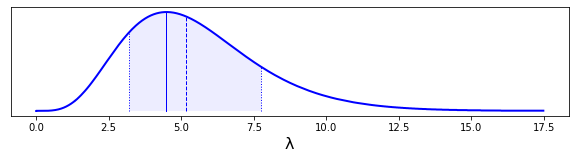

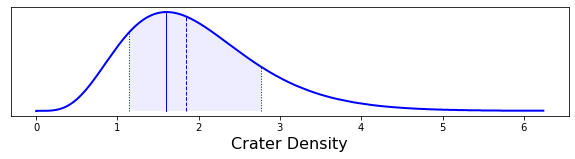

In [294]:
plot_pdf(binned_incremental.iloc[20]['λ_pdf'],binned_incremental.iloc[20]['P_pdf'])
plt.xlabel('λ',size=16)
plt.yticks([])
plot_pdf(binned_incremental.iloc[20]['density_pdf'],binned_incremental.iloc[20]['P_pdf'])
plt.xlabel('Crater Density',size=16)
plt.yticks([])

There is also a calculation function for the differential plot.

In [302]:
binned_differential=calc_differential(ds,area,n_points=2000,random_sigma=0.05)
binned_differential

,D,count,lower,max,median,upper,density_pdf,P_pdf,λ_pdf
0,0.006742,7.110338e-08,212.343574,2.901331e-05,282.834616,468.384025,"[0.0, 0.0014810431690717208, 0.002962086338143...","[0.004140502094270754, 0.004131914709624274, 0...","[0.0, 0.0041490994693807815, 0.008298198938761..."
1,0.007662,1.575015e-03,187.889708,5.677210e-01,250.397508,414.099816,"[0.0, 0.0014818307920236376, 0.002963661584047...","[0.004104327108906398, 0.004100280487817753, 0...","[0.0, 0.004151305972229661, 0.0083026119444593..."
2,0.008708,2.209448e+00,435.187695,7.023176e+02,916.412303,644.269268,"[0.0, 0.0023714524274017204, 0.004742904854803...","[1.4454412423379605e-06, 1.4454412423379605e-0...","[0.0, 0.006643555173588436, 0.0132871103471768..."
3,0.009896,8.562036e+01,2507.976457,2.397677e+04,24163.525789,2694.587164,"[0.0, 0.021922185977716564, 0.0438443719554331...","[1.442497004115151e-08, 1.442497004115151e-08,...","[0.0, 0.061414367999023466, 0.1228287359980469..."
4,0.011247,1.864019e+02,3290.066433,4.595866e+04,46123.055312,3454.405390,"[0.0, 0.042639969989830814, 0.0852799399796616...","[1.0963347802302171e-08, 1.0963347802302171e-0...","[0.0, 0.11945463883413117, 0.23890927766826234..."
5,0.012782,1.533463e+02,2620.714031,3.327632e+04,33421.012329,2765.346951,"[0.0, 0.03595106189630979, 0.07190212379261958...","[1.1629090966390929e-08, 1.1629090966390929e-0...","[0.0, 0.10071585687211737, 0.20143171374423474..."
6,0.014526,1.064820e+02,1912.916264,2.033239e+04,20459.719349,2040.170258,"[0.0, 0.02630570438655332, 0.05261140877310664...","[1.3206767828062321e-08, 1.3206767828062321e-0...","[0.0, 0.07369466764452605, 0.1473893352890521,..."
7,0.016508,7.770608e+01,1431.304743,1.305460e+04,13166.642216,1543.251779,"[0.0, 0.020238705903542507, 0.0404774118070850...","[1.5051819746880016e-08, 1.5051819746880016e-0...","[0.0, 0.056698147413200395, 0.1133962948264007..."
8,0.018761,5.129692e+01,1016.214169,7.581782e+03,7680.373313,1114.678583,"[0.0, 0.014505183413517735, 0.0290103668270354...","[1.8536855583984688e-08, 1.8536855583984688e-0...","[0.0, 0.040635850501250924, 0.0812717010025018..."
9,0.021321,3.491190e+01,732.313323,4.539624e+03,4626.383570,818.910184,"[0.0, 0.010810922545070097, 0.0216218450901401...","[2.3503523594962265e-08, 2.3503523594962265e-0...","[0.0, 0.030286485858060017, 0.0605729717161200..."


And for the R plot.

In [314]:
binned_R=calc_R(ds,area,n_points=2000,random_sigma=0.05)
binned_R

/opt/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:333: RuntimeWarning: Mean of empty slice.
  return np.exp(log_a.mean(axis=axis))
/opt/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,D,count,lower,max,median,upper,density_pdf,P_pdf,λ_pdf
0,0.006742,7.110338e-08,0.000065,8.892433e-12,0.000087,0.000144,"[0.0, 5.189006616629897e-07, 1.037801323325979...","[0.004140502094270754, 0.004131914709624274, 0...","[0.0, 0.0041490994693807815, 0.008298198938761..."
1,0.007662,1.575015e-03,0.000085,2.554024e-07,0.000113,0.000186,"[0.0, 6.731703314038109e-07, 1.346340662807621...","[0.004104327108906398, 0.004100280487817753, 0...","[0.0, 0.004151305972229661, 0.0083026119444593..."
2,0.008708,2.209448e+00,0.000287,4.637567e-04,0.000605,0.000425,"[0.0, 1.3944629206968732e-06, 2.78892584139374...","[1.4454412423379605e-06, 1.4454412423379605e-0...","[0.0, 0.006643555173588436, 0.0132871103471768..."
3,0.009896,8.562036e+01,0.002431,2.323882e-02,0.023420,0.002612,"[0.0, 1.6668899727283105e-05, 3.33377994545662...","[1.442497004115151e-08, 1.442497004115151e-08,...","[0.0, 0.061414367999023466, 0.1228287359980469..."
4,0.011247,1.864019e+02,0.004681,6.538187e-02,0.065616,0.004914,"[0.0, 4.189960529161919e-05, 8.379921058323838...","[1.0963347802302171e-08, 1.0963347802302171e-0...","[0.0, 0.11945463883413117, 0.23890927766826234..."
5,0.012782,1.533463e+02,0.005472,6.948514e-02,0.069787,0.005774,"[0.0, 4.5636942997332735e-05, 9.12738859946654...","[1.1629090966390929e-08, 1.1629090966390929e-0...","[0.0, 0.10071585687211737, 0.20143171374423474..."
6,0.014526,1.064820e+02,0.005863,6.231774e-02,0.062708,0.006253,"[0.0, 4.3129206897963314e-05, 8.62584137959266...","[1.3206767828062321e-08, 1.3206767828062321e-0...","[0.0, 0.07369466764452605, 0.1473893352890521,..."
7,0.016508,7.770608e+01,0.006439,5.872913e-02,0.059233,0.006943,"[0.0, 4.28516363678411e-05, 8.57032727356822e-...","[1.5051819746880016e-08, 1.5051819746880016e-0...","[0.0, 0.056698147413200395, 0.1133962948264007..."
8,0.018761,5.129692e+01,0.006710,5.006428e-02,0.050715,0.007360,"[0.0, 3.9659391879697496e-05, 7.93187837593949...","[1.8536855583984688e-08, 1.8536855583984688e-0...","[0.0, 0.040635850501250924, 0.0812717010025018..."
9,0.021321,3.491190e+01,0.007098,4.399904e-02,0.044840,0.007937,"[0.0, 3.816968793809285e-05, 7.63393758761857e...","[2.3503523594962265e-08, 2.3503523594962265e-0...","[0.0, 0.030286485858060017, 0.0605729717161200..."


In [313]:
def calc_incremental(ds,area,bin_width_exponent=math.log(10,2)/18,x_axis_position='left',n_points=2000,\
                           skip_zero_crater_bins=False,reference_point=2.0,random_sigma=0.0,\
                     lower_bin_adjustment=0.6,upper_bin_adjustment=1.3):
    
    if random_sigma!=0:
        bin_min = math.ceil(math.log(lower_bin_adjustment*min(ds)/reference_point,2)/bin_width_exponent)
        bin_max = math.ceil(math.log(upper_bin_adjustment*max(ds)/reference_point,2)/bin_width_exponent)
        bins = [reference_point*2**(bin_width_exponent*n) for n in list(range(bin_min,bin_max+1))]
        bin_counts = np.array([norm(loc=d,scale=random_sigma*d).cdf(bins[1:])-\
                norm(loc=d,scale=random_sigma*d).cdf(bins[:-1]) for d in ds]).sum(axis=0)
    else:
        bin_min = math.ceil(math.log(min(ds)/reference_point,2)/bin_width_exponent)
        bin_max = math.ceil(math.log(max(ds)/reference_point,2)/bin_width_exponent)
        bins = [reference_point*2**(bin_width_exponent*n) for n in list(range(bin_min,bin_max+1))]
        bin_counts,bin_array=np.histogram(ds,bins)
    
    if x_axis_position=='left':
        x_array = np.array([reference_point*2.0**(bin_width_exponent*(n)) for n in list(range(bin_min,bin_max))])
        y_array = np.array(bin_counts)
        if skip_zero_crater_bins:
            x_array = x_array[bin_counts!=0]
            y_array = y_array[bin_counts!=0]
    elif x_axis_position=='center':
        x_array = np.array([reference_point*2.0**(bin_width_exponent*(n+0.5)) for n in list(range(bin_min,bin_max))])
        y_array = np.array(bin_counts)
        if skip_zero_crater_bins:
            x_array = x_array[bin_counts!=0]
            y_array = y_array[bin_counts!=0]
    elif x_axis_position=='gmean':
        x_array = np.zeros(len(bin_counts))
        x_array[bin_counts!=0] = np.array([gmean(ds[np.digitize(ds,bin_array)==i]) for i in np.array(range(1,\
                    len(bin_counts)+1))[bin_counts!=0]])
        x_array[bin_counts==0] = np.array([reference_point*2.0**(bin_width_exponent*(n+0.5)) for n in \
                    np.array(list(range(bin_min,bin_max)))[bin_counts==0]])
        y_array = np.array(bin_counts)
        if skip_zero_crater_bins:
            x_array = x_array[bin_counts!=0]
            y_array = y_array[bin_counts!=0]
    else:
        raise ValueError('x_axis_position must be one of the following: {\'left\',\'center\',\'gmean\'}')
    
    lower_list=ig_lower(y_array)/area
    med_list=ig_50(y_array)/area
    upper_list=ig_upper(y_array)/area
        
    density_list=[]
    λ_list=[]
    P_list=[]
    for N in y_array:
        λ,P=igpdf(N,n_points=n_points)
        density_list.append(λ/area)
        λ_list.append(λ)
        P_list.append(P)
        
    return pd.DataFrame({'D':x_array,'count':y_array,'lower':lower_list,'max':y_array/area,\
                         'median':med_list,'upper':upper_list,'density_pdf':density_list,\
                         'P_pdf':P_list,'λ_pdf':λ_list})

def calc_differential(ds,area,n_points=2000,bin_width_exponent=neukum_bwe,do_correction=True,\
                production_function=npf_new,reference_point=2.0,x_axis_position='center',\
                skip_zero_crater_bins=False,lower_bin_adjustment=0.6,upper_bin_adjustment=1.3,random_sigma=0):

    if random_sigma!=0:
        bin_min = math.ceil(math.log(lower_bin_adjustment*min(ds)/reference_point,2)/bin_width_exponent)
        bin_max = math.ceil(math.log(upper_bin_adjustment*max(ds)/reference_point,2)/bin_width_exponent)
        bins = [reference_point*2**(bin_width_exponent*n) for n in list(range(bin_min,bin_max+1))]
        bin_gmeans = [reference_point*2.0**(bin_width_exponent*(n+0.5)) for n in list(range(bin_min,bin_max))]
        bin_widths = np.array([bins[i+1]-bins[i] for i in list(range(len(bins)-1))])
        bin_counts = np.array([norm(loc=d,scale=random_sigma*d).cdf(bins[1:])-\
                norm(loc=d,scale=random_sigma*d).cdf(bins[:-1]) for d in ds]).sum(axis=0)
    else:
        bin_min = math.ceil(math.log(min(ds)/reference_point,2)/bin_width_exponent)
        bin_max = math.ceil(math.log(max(ds)/reference_point,2)/bin_width_exponent)
        bins = [reference_point*2**(bin_width_exponent*n) for n in list(range(bin_min,bin_max+1))]
        bin_gmeans = [reference_point*2.0**(bin_width_exponent*(n+0.5)) for n in list(range(bin_min,bin_max))]
        bin_widths = np.array([bins[i+1]-bins[i] for i in list(range(len(bins)-1))])
        bin_counts,bin_array=np.histogram(ds,bins)
    
    if do_correction:
        local_slope = np.array([(np.log10(production_function(bins[n+1])) - \
                np.log10(production_function(bins[n]))) / (np.log10(bins[n+1]) - np.log10(bins[n])) \
                for n in list(range(len(bins)-1))])
        correction_factors = np.array((2**(bin_width_exponent*local_slope/2) - 2**(-1*bin_width_exponent*\
                local_slope/2)) / (local_slope * (2**(bin_width_exponent/2) - 2**(-1*bin_width_exponent/2))))
    else:
        correction_factors = np.ones(len(bin_gmeans))
    
    if x_axis_position=='left':
        x_array = np.array([reference_point*2.0**(bin_width_exponent*(n)) for n in list(range(bin_min,bin_max))])
        y_array = np.array(bin_counts)
        if skip_zero_crater_bins:
            x_array = x_array[bin_counts!=0]
            y_array = y_array[bin_counts!=0]
    elif x_axis_position=='center':
        x_array = np.array([reference_point*2.0**(bin_width_exponent*(n+0.5)) for n in list(range(bin_min,bin_max))])
        y_array = np.array(bin_counts)
        if skip_zero_crater_bins:
            x_array = x_array[bin_counts!=0]
            y_array = y_array[bin_counts!=0]
    elif x_axis_position=='gmean':
        x_array = np.zeros(len(bin_counts))
        x_array[bin_counts!=0] = np.array([gmean(ds[np.digitize(ds,bin_array)==i]) for i in np.array(range(1,\
                    len(bin_counts)+1))[bin_counts!=0]])
        x_array[bin_counts==0] = np.array([reference_point*2.0**(bin_width_exponent*(n+0.5)) for n in \
                    np.array(list(range(bin_min,bin_max)))[bin_counts==0]])
        y_array = np.array(bin_counts)
        if skip_zero_crater_bins:
            x_array = x_array[bin_counts!=0]
            y_array = y_array[bin_counts!=0]
    elif x_axis_position=='Michael and Neukum (2010)':
        if not skip_zero_crater_bins:
            raise ValueError('Michael and Neukum (2010) only used bins without zero craters in them.  To fix, set'\
                            +' skip_zero_crater_bins=True')
        x_array = np.array([reference_point*2.0**(bin_width_exponent*(n+0.5)) for n in list(range(bin_min,bin_max))])
        mn10sr=np.where((bin_counts==0))[0]
        if mn10sr.shape[0]>0:
            mn10d=mn10sr[0]
            x_array = np.append(x_array[:mn10d],np.array(ds)[np.array(ds)>bins[mn10d]])
            y_array = np.append(np.array(bin_counts)[:mn10d],np.flip(np.array(range(len(np.array(ds)\
                                [np.array(ds)>bins[mn10d]])))+1))
        else:
            y_array = np.array(bin_counts)
    else:
        raise ValueError('x_axis_position must be one of the following: {\'left\',\'center\',\'gmean\','+\
                         '\'Michael and Neukum (2010)\'}')
        
    if skip_zero_crater_bins:
        bin_widths = bin_widths[bin_counts!=0]
        correction_factors = correction_factors[bin_counts!=0]
        
    lower_list=ig_lower(y_array)/area/bin_widths/correction_factors
    med_list=ig_50(y_array)/area/bin_widths/correction_factors
    upper_list=ig_upper(y_array)/area/bin_widths/correction_factors
    diff_list=y_array/area/bin_widths/correction_factors

    density_list=[]
    λ_list=[]
    P_list=[]
    for i in list(range(len(bin_counts))):
        λ,P=igpdf(y_array[i],n_points=n_points)
        density_list.append(λ/area/bin_widths[i]/correction_factors[i])
        λ_list.append(λ)
        P_list.append(P)
        
    density_list=[]
    λ_list=[]
    P_list=[]
    for N in y_array:
        λ,P=igpdf(N,n_points=n_points)
        density_list.append(λ/area)
        λ_list.append(λ)
        P_list.append(P)
        
    return pd.DataFrame({'D':x_array,'count':y_array,'lower':lower_list,'max':diff_list,\
                         'median':med_list,'upper':upper_list,'density_pdf':density_list,\
                         'P_pdf':P_list,'λ_pdf':λ_list})

def calc_R(ds,area,n_points=2000,bin_width_exponent=neukum_bwe,do_correction=True,production_function=npf_new\
          ,reference_point=2.0,x_axis_position='center',skip_zero_crater_bins=False\
          ,lower_bin_adjustment=0.6,upper_bin_adjustment=1.3,random_sigma=0):

    if random_sigma!=0:
        bin_min = math.ceil(math.log(lower_bin_adjustment*min(ds)/reference_point,2)/bin_width_exponent)
        bin_max = math.ceil(math.log(upper_bin_adjustment*max(ds)/reference_point,2)/bin_width_exponent)
        bins = [reference_point*2**(bin_width_exponent*n) for n in list(range(bin_min,bin_max+1))]
        bin_counts = np.array([norm(loc=d,scale=random_sigma*d).cdf(bins[1:])-\
                norm(loc=d,scale=random_sigma*d).cdf(bins[:-1]) for d in ds]).sum(axis=0)
    else:
        bin_min = math.ceil(math.log(min(ds)/reference_point,2)/bin_width_exponent)
        bin_max = math.ceil(math.log(max(ds)/reference_point,2)/bin_width_exponent)
        bins = [reference_point*2**(bin_width_exponent*n) for n in list(range(bin_min,bin_max+1))]

        bin_counts,bin_array=np.histogram(ds,bins)
        
    binned = np.digitize(ds,bins)
    bin_gmeans = np.zeros(len(bin_counts))
    bin_gmeans[bin_counts!=0] = np.array([gmean(ds[binned==i]) for i in np.array(range(1,len(bin_counts)+1))\
                                          [bin_counts!=0]])
    bin_gmeans[bin_counts==0] = np.array([reference_point*2.0**(bin_width_exponent*(n+0.5)) for n in \
                        np.array(range(bin_min,bin_max))[bin_counts==0]])
    bin_widths = np.array([bins[i+1]-bins[i] for i in list(range(len(bins)-1))])
    
    if do_correction:
        local_slope = np.array([(np.log10(production_function(bins[n+1])) - \
                np.log10(production_function(bins[n]))) / (np.log10(bins[n+1]) - np.log10(bins[n])) \
                for n in list(range(len(bins)-1))])
        correction_factors = np.array((2**(bin_width_exponent*local_slope/2) - 2**(-1*bin_width_exponent*\
                local_slope/2)) / (local_slope * (2**(bin_width_exponent/2) - 2**(-1*bin_width_exponent/2))))
    else:
        correction_factors = np.ones(len(bin_gmeans))
    bin_adjustments = np.array([(bins[i+1]*bins[i])**1.5 for i in list(range(len(bins)-1))])
    
    if x_axis_position=='left':
        x_array = np.array([reference_point*2.0**(bin_width_exponent*(n)) for n in list(range(bin_min,bin_max))])
        y_array = np.array(bin_counts)
        if skip_zero_crater_bins:
            x_array = x_array[bin_counts!=0]
            y_array = y_array[bin_counts!=0]
    elif x_axis_position=='center':
        x_array = np.array([reference_point*2.0**(bin_width_exponent*(n+0.5)) for n in list(range(bin_min,bin_max))])
        y_array = np.array(bin_counts)
        if skip_zero_crater_bins:
            x_array = x_array[bin_counts!=0]
            y_array = y_array[bin_counts!=0]
    elif x_axis_position=='gmean':
        x_array = np.zeros(len(bin_counts))
        x_array[bin_counts!=0] = np.array([gmean(ds[np.digitize(ds,np.array(bins))==i]) for i in np.array(range(1,\
                    len(bin_counts)+1))[bin_counts!=0]])
        x_array[bin_counts==0] = np.array([reference_point*2.0**(bin_width_exponent*(n+0.5)) for n in \
                    np.array(list(range(bin_min,bin_max)))[bin_counts==0]])
        y_array = np.array(bin_counts)
        if skip_zero_crater_bins:
            x_array = x_array[bin_counts!=0]
            y_array = y_array[bin_counts!=0]
    elif x_axis_position=='Michael and Neukum (2010)':
        if not skip_zero_crater_bins:
            raise ValueError('Michael and Neukum (2010) only used bins without zero craters in them.  To fix, set'\
                            +' skip_zero_crater_bins=True')
        x_array = np.array([reference_point*2.0**(bin_width_exponent*(n+0.5)) for n in list(range(bin_min,bin_max))])
        mn10sr=np.where((bin_counts==0))[0]
        if mn10sr.shape[0]>0:
            mn10d=mn10sr[0]
            x_array = np.append(x_array[:mn10d],np.array(ds)[np.array(ds)>bins[mn10d]])
            y_array = np.append(np.array(bin_counts)[:mn10d],np.flip(np.array(range(len(np.array(ds)\
                                [np.array(ds)>bins[mn10d]])))+1))
        else:
            y_array = np.array(bin_counts)
    else:
        raise ValueError('x_axis_position must be one of the following: {\'left\',\'center\',\'gmean\','+\
                         '\'Michael and Neukum (2010)\'}')
        
    if skip_zero_crater_bins:
        bin_widths = bin_widths[bin_counts!=0]
        correction_factors = correction_factors[bin_counts!=0]
        bin_adjustments = bin_adjustments[bin_counts!=0]
    
    lower_list=ig_lower(y_array)/area/bin_widths/correction_factors*bin_adjustments
    med_list=ig_50(y_array)/area/bin_widths/correction_factors*bin_adjustments
    upper_list=ig_upper(y_array)/area/bin_widths/correction_factors*bin_adjustments
    r_list=y_array/area/bin_widths/correction_factors*bin_adjustments

    density_list=[]
    P_list=[]
    λ_list=[]
    for i in list(range(len(bin_counts))):
        λ,P=igpdf(bin_counts[i],n_points=n_points)
        density_list.append(λ/area/bin_widths[i]/correction_factors[i]*bin_adjustments[i])
        P_list.append(P)
        λ_list.append(λ)
        
    return pd.DataFrame({'D':x_array,'count':y_array,'lower':lower_list,'max':r_list,\
                         'median':med_list,'upper':upper_list,'density_pdf':density_list,\
                         'P_pdf':P_list,'λ_pdf':λ_list})

In [309]:
def plot_R(ds,area,ax='None',bin_width_exponent=neukum_bwe,do_correction=True,production_function=npf_new,color='black'\
          ,reference_point=2.0,x_axis_position='center',skip_zero_crater_bins=False\
          ,lower_bin_adjustment=0.6,upper_bin_adjustment=1.3,random_sigma=0):
    if ax=='None':
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111)
        
    if random_sigma!=0:
        bin_min = math.ceil(math.log(lower_bin_adjustment*min(ds)/reference_point,2)/bin_width_exponent)
        bin_max = math.ceil(math.log(upper_bin_adjustment*max(ds)/reference_point,2)/bin_width_exponent)
        bins = [reference_point*2**(bin_width_exponent*n) for n in list(range(bin_min,bin_max+1))]
        bin_counts = np.array([norm(loc=d,scale=random_sigma*d).cdf(bins[1:])-\
                norm(loc=d,scale=random_sigma*d).cdf(bins[:-1]) for d in ds]).sum(axis=0)
    else:
        bin_min = math.ceil(math.log(min(ds)/reference_point,2)/bin_width_exponent)
        bin_max = math.ceil(math.log(max(ds)/reference_point,2)/bin_width_exponent)
        bins = [reference_point*2**(bin_width_exponent*n) for n in list(range(bin_min,bin_max+1))]

        bin_counts,bin_array=np.histogram(ds,bins)
        
    binned = np.digitize(ds,bins)
    bin_gmeans = np.zeros(len(bin_counts))
    bin_gmeans[bin_counts!=0] = np.array([gmean(ds[binned==i]) for i in np.array(range(1,len(bin_counts)+1))\
                                          [bin_counts!=0]])
    bin_gmeans[bin_counts==0] = np.array([reference_point*2.0**(bin_width_exponent*(n+0.5)) for n in \
                        np.array(range(bin_min,bin_max))[bin_counts==0]])
    bin_widths = np.array([bins[i+1]-bins[i] for i in list(range(len(bins)-1))])
    
    if do_correction:
        local_slope = np.array([(np.log10(production_function(bins[n+1])) - \
                np.log10(production_function(bins[n]))) / (np.log10(bins[n+1]) - np.log10(bins[n])) \
                for n in list(range(len(bins)-1))])
        correction_factors = np.array((2**(bin_width_exponent*local_slope/2) - 2**(-1*bin_width_exponent*\
                local_slope/2)) / (local_slope * (2**(bin_width_exponent/2) - 2**(-1*bin_width_exponent/2))))
    else:
        correction_factors = np.ones(len(bin_gmeans))
    bin_adjustments = np.array([(bins[i+1]*bins[i])**1.5 for i in list(range(len(bins)-1))])
    
    if x_axis_position=='left':
        x_array = np.array([reference_point*2.0**(bin_width_exponent*(n)) for n in list(range(bin_min,bin_max))])
        y_array = np.array(bin_counts)
        if skip_zero_crater_bins:
            x_array = x_array[bin_counts!=0]
            y_array = y_array[bin_counts!=0]
    elif x_axis_position=='center':
        x_array = np.array([reference_point*2.0**(bin_width_exponent*(n+0.5)) for n in list(range(bin_min,bin_max))])
        y_array = np.array(bin_counts)
        if skip_zero_crater_bins:
            x_array = x_array[bin_counts!=0]
            y_array = y_array[bin_counts!=0]
    elif x_axis_position=='gmean':
        x_array = np.zeros(len(bin_counts))
        x_array[bin_counts!=0] = np.array([gmean(ds[np.digitize(ds,np.array(bins))==i]) for i in np.array(range(1,\
                    len(bin_counts)+1))[bin_counts!=0]])
        x_array[bin_counts==0] = np.array([reference_point*2.0**(bin_width_exponent*(n+0.5)) for n in \
                    np.array(list(range(bin_min,bin_max)))[bin_counts==0]])
        y_array = np.array(bin_counts)
        if skip_zero_crater_bins:
            x_array = x_array[bin_counts!=0]
            y_array = y_array[bin_counts!=0]
    elif x_axis_position=='Michael and Neukum (2010)':
        if not skip_zero_crater_bins:
            raise ValueError('Michael and Neukum (2010) only used bins without zero craters in them.  To fix, set'\
                            +' skip_zero_crater_bins=True')
        x_array = np.array([reference_point*2.0**(bin_width_exponent*(n+0.5)) for n in list(range(bin_min,bin_max))])
        mn10sr=np.where((bin_counts==0))[0]
        if mn10sr.shape[0]>0:
            mn10d=mn10sr[0]
            x_array = np.append(x_array[:mn10d],np.array(ds)[np.array(ds)>bins[mn10d]])
            y_array = np.append(np.array(bin_counts)[:mn10d],np.flip(np.array(range(len(np.array(ds)\
                                [np.array(ds)>bins[mn10d]])))+1))
        else:
            y_array = np.array(bin_counts)
    else:
        raise ValueError('x_axis_position must be one of the following: {\'left\',\'center\',\'gmean\','+\
                         '\'Michael and Neukum (2010)\'}')
        
    if skip_zero_crater_bins:
        bin_widths = bin_widths[bin_counts!=0]
        correction_factors = correction_factors[bin_counts!=0]
        bin_adjustments = bin_adjustments[bin_counts!=0]
    
    lower_list=ig_lower(y_array)/area/bin_widths/correction_factors*bin_adjustments
    med_list=ig_50(y_array)/area/bin_widths/correction_factors*bin_adjustments
    upper_list=ig_upper(y_array)/area/bin_widths/correction_factors*bin_adjustments
    r_list=y_array/area/bin_widths/correction_factors*bin_adjustments
    plt.rcParams['lines.linewidth'] = 1.0
    data = pd.DataFrame({'D':x_array,'lower':lower_list,'med':med_list,'upper':upper_list})
    data.plot(y='med',x='D', \
                              yerr=np.array([data[['lower','upper']].values.transpose()]), 
                              logx=True, kind='scatter', 
                              color=color, s=0,ax=ax)
    ax.loglog(x_array,med_list,marker='_',ls='',mfc='none',mec=color,mew=1.2,ms=10)
    ax.loglog(x_array,r_list,marker='o',ls='',mfc=color,mec=color,mew=1.2,ms=4)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.xlim([bins[0],bins[-1]])
    ymax=np.max(med_list+upper_list)
    ymin=np.min(med_list-lower_list)
    yrange=np.log10(ymax/ymin)
    plt.ylim([ymin/(1.15*yrange),ymax*(1.15*yrange)])
    plt.ylabel('R value',size=18)
    plt.xlabel('Crater Diameter (km)',size=18)
    plt.grid(which='major', linestyle=':', linewidth=0.5, color='black')
    plt.grid(which='minor', linestyle=':', linewidth=0.25, color='gray')
    return ax
